<a href="https://colab.research.google.com/github/text123580/ml20200716/blob/master/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import zipfile
f = zipfile.ZipFile("drive/My Drive/AI_04/train.zip")
f.extractall("datas")

In [ ]:
import glob
import pandas as pd
dogs = glob.glob("datas/train/dog.*")
cats = glob.glob("datas/train/cat.*")
df = pd.DataFrame({
    "path":dogs + cats,
    "ans":[0] * len(dogs) + [1] * len(cats)
})
df

,path,ans
0,datas/train/dog.1159.jpg,0
1,datas/train/dog.6116.jpg,0
2,datas/train/dog.7307.jpg,0
3,datas/train/dog.2836.jpg,0
4,datas/train/dog.2364.jpg,0
...,...,...
24995,datas/train/cat.10637.jpg,1
24996,datas/train/cat.8653.jpg,1
24997,datas/train/cat.6507.jpg,1
24998,datas/train/cat.2566.jpg,1


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in cnn.layers:
    layer.trainable = False
mlp = [
    # 512 * 4 = 2048(一半不訓練[原本平均. 標準差], 一半訓練[後來平均, 後來標準差])
    BatchNormalization(),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.25),
    Dense(2, activation="softmax")
]
model = Sequential(cnn.layers + mlp)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

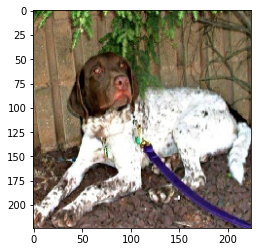

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
img = load_img(df["path"][0], target_size=(224, 224))
plt.imshow(img)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
# 只要開始處理, 就不要df, 改用np.array
x = np.array(df["path"])
y = np.array(df["ans"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(22500,)
(22500,)
(2500,)
(2500,)


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), batch)
    x_idx, y_idx = x[idx], y[idx]
    x_ori, x_norm, y_ori = [], [], y_idx
    for p in x_idx:
        img = np.array(load_img(p, target_size=(224, 224)))
        img_pre = preprocess_input(img)
        x_ori.append(img)
        x_norm.append(img_pre)
    return np.array(x_ori), np.array(x_norm), np.array(y_ori)
# get_data(x_train, y_train, 1)

In [ ]:
for i in range(10):
    print("[times]:", i)
    _, x_batch, y_batch = get_data(x_train, y_train)
    result = model.train_on_batch(x_batch, y_batch)
    print("[Train]:", result)
    _, x_batch, y_batch = get_data(x_test, y_test, 100)
    result = model.test_on_batch(x_batch, y_batch)
    print("[Test]:", result)

[times]: 0
[Train]: [1.2964342832565308, 0.44999998807907104]
[Test]: [11.620627403259277, 0.75]
[times]: 1
[Train]: [0.45456284284591675, 0.800000011920929]
[Test]: [23.38695526123047, 0.6700000166893005]
[times]: 2
[Train]: [1.1890552043914795, 0.800000011920929]
[Test]: [18.55707359313965, 0.6899999976158142]
[times]: 3
[Train]: [1.4094724655151367, 0.8999999761581421]
[Test]: [28.991098403930664, 0.6100000143051147]
[times]: 4
[Train]: [0.21923701465129852, 0.949999988079071]
[Test]: [26.20486831665039, 0.7200000286102295]
[times]: 5
[Train]: [0.6283632516860962, 0.8999999761581421]
[Test]: [22.196435928344727, 0.7400000095367432]
[times]: 6
[Train]: [0.24514970183372498, 0.8999999761581421]
[Test]: [20.384990692138672, 0.7300000190734863]
[times]: 7
[Train]: [0.0002358526980970055, 1.0]
[Test]: [10.960537910461426, 0.800000011920929]
[times]: 8
[Train]: [1.0270360708236694, 0.800000011920929]
[Test]: [6.8296308517456055, 0.800000011920929]
[times]: 9
[Train]: [0.41915398836135864,

In [ ]:
model.predict(x_batch)

array([[1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [2.6632575e-04, 9.9973363e-01],
       [1.0000000e+00, 6.1416286e-23],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [5.4767182e-34, 1.0000000e+00],
       [1.0000000e+00, 6.4604912e-34],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [3.2533255e-01, 6.7466748e-01],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 3.0512737e-29],
       [0.0000000e+00, 1.0000000e+00],
       [1.0279116e-33, 1.0000000e+00],
       [1.0000000e+00, 5.7292191e-29],
       [1.0000000e+00, 1.6050835e-21],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.9647111e-06, 9.9999809e-01],
       [1.0000000e+00, 0.0000000e+00],
       [9.9999917e-01, 8.5549203e-07],
       [1.0000000e+00, 0.

In [ ]:
x_ori, x_batch, y_batch = get_data(x_test, y_test, 1000)
model.evaluate(x_batch, y_batch)

32/32 [==============================] - 4s 122ms/step - loss: 15.2915 - accuracy: 0.7850


[15.29150676727295, 0.7850000262260437]

In [ ]:
# argmax: 找最大值的index, 通常都是最後一個軸(-1)
pre = model.predict(x_batch).argmax(axis=-1)
pre

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,

In [ ]:
trans = ["dog", "cat"]

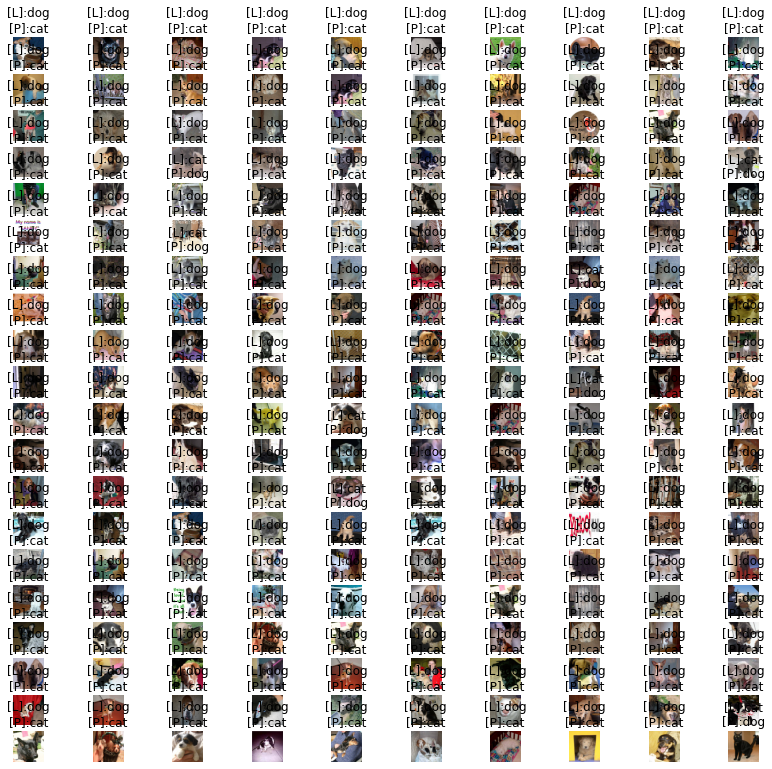

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14, 14))
idx = np.nonzero(pre != y_batch)[0]
idx = idx[:200]
width = 10
height = len(idx) // width + 1
for i, d  in enumerate(idx):
    img, label, p = x_ori[d], y_batch[d], pre[d]
    t = "[L]:{}\n[P]:{}".format(trans[label], trans[p])
    plt.subplot(height, width, i+1)
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)

輸入網址:https://images.chinatimes.com/newsphoto/2020-07-04/900/20200704002959.jpg
dog 的機率: 0.68
cat 的機率: 0.32


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


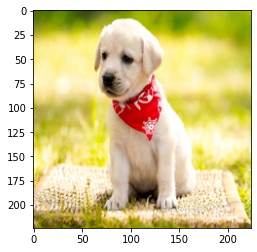

In [ ]:
# https://images.chinatimes.com/newsphoto/2020-07-04/900/20200704002959.jpg
import requests
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img

url = input("輸入網址:")
# 純文字: stream不加, 檔案: stream=True
# verify=False 防火牆調低
response = requests.get(url, stream=True, verify=False)
img = Image.open(response.raw).resize((224, 224))
img = np.array(img)
img_np = np.array(img).reshape(1, 224, 224, 3) / 255
pre = model.predict(img_np)[0]
for i in range(2):
    print(trans[i], "的機率:", round(pre[i], 2))
plt.imshow(np.array(img), cmap="Reds")